# Machine Learning com PyTorch

## Introdução

Machine Learning utilizando o framework PyTorch.



In [1]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import time
import os


import matplotlib.pyplot as plt
%matplotlib inline

# Configurando hiperparâmetros.
args = {
    'epoch_num': 200,     # Número de épocas.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 3,     # Número de threads do dataloader.
    'batch_size': 20,     # Tamanho do batch.
}
print("GPU está disponível?: ",torch.cuda.is_available())  # Verifica se a GPU está disponível
print("Nome da GPU: ",torch.cuda.get_device_name(0))  # Obtém o nome da GPU

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

GPU está disponível?:  True
Nome da GPU:  NVIDIA GeForce GTX 1650
cuda


### Baixando o dataset


In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip  

--2024-05-08 21:57:07--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase     [ <=>                ] 273,43K  19,4KB/s    in 13s     

2024-05-08 21:57:21 (21,4 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [3]:
df = pd.read_csv('hour.csv')
print(len(df))
df.head()

17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
# Train/Test split
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test  = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_test.head())

df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)
!ls

13903 3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12663,12664,2012-06-16,2,1,6,20,0,6,0,2,0.66,0.6212,0.47,0.1940,123,229,352
1801,1802,2011-03-20,1,0,3,18,0,0,0,1,0.38,0.3939,0.40,0.3582,58,98,156
16567,16568,2012-11-28,4,1,11,1,0,3,1,2,0.26,0.2576,0.75,0.2239,0,12,12
8817,8818,2012-01-08,1,1,1,5,0,0,0,2,0.32,0.3333,0.49,0.1045,0,2,2
2608,2609,2011-04-23,2,0,4,14,0,6,0,1,0.58,0.5455,0.78,0.3582,182,209,391


Bike-Sharing-Dataset.zip  bike_train.csv  hour.csv		Readme.txt
bike_test.csv		  day.csv	  neural_network.ipynb


In [5]:
class Bicicletinha(Dataset):
  def __init__(self, csv_path, scaler_feat=None, scaler_label=None):
  
    self.dados = pd.read_csv(csv_path).to_numpy()
    
  def __getitem__(self, idx):
    
    sample = self.dados[idx][2:14]
    label  = self.dados[idx][-1:]
    
    # converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label  = torch.from_numpy(label.astype(np.float32))
    
    return sample, label
    
  def __len__(self):
    return len(self.dados)

In [6]:
dataset = Bicicletinha('bike_train.csv')
dado, rotulo = dataset[0]
print(rotulo)
print(dado)

tensor([373.])
tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])


In [7]:
train_set = Bicicletinha('bike_train.csv')
test_set  = Bicicletinha('bike_test.csv')

print('Tamanho do treino: ' + str(len(train_set)) + ' amostras')
print('Tamanho do teste: ' + str(len(test_set)) + ' amostras')

Tamanho do treino: 13903 amostras
Tamanho do teste: 3476 amostras


In [8]:
# Criando dataloader
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

In [9]:
for batch in test_loader:
  
  dado, rotulo = batch
  print('## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size())
  
#   break

## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])
## Dimensionalidade do batch ##
torch.Size([20, 12]

In [10]:
class MLP(nn.Module):
  
  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()
    
    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, out_size),
        nn.ReLU(),
    )

  def forward(self, X):
    
    hidden = self.features(X)
    output = self.classifier(hidden)
    
    return output

input_size  = train_set[0][0].size(0)
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [11]:
criterion = nn.L1Loss().to(args['device'])

optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [12]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()
    

In [13]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()
    

In [14]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 164.3138 +/- 42.0975, Time: 1.60
********** Validate **********
Epoch 0, Loss: 125.7965 +/- 30.3890, Time: 0.31

#################### Train ####################
Epoch 1, Loss: 130.6107 +/- 25.6430, Time: 1.21
********** Validate **********
Epoch 1, Loss: 126.6351 +/- 24.3811, Time: 0.30

#################### Train ####################
Epoch 2, Loss: 122.8896 +/- 30.2196, Time: 1.32
********** Validate **********
Epoch 2, Loss: 125.2943 +/- 31.5335, Time: 0.29

#################### Train ####################
Epoch 3, Loss: 120.4436 +/- 31.0856, Time: 1.32
********** Validate **********
Epoch 3, Loss: 117.2516 +/- 26.3097, Time: 0.33

#################### Train ####################
Epoch 4, Loss: 118.8115 +/- 24.6739, Time: 1.41
********** Validate **********
Epoch 4, Loss: 114.5222 +/- 28.4489, Time: 0.29

#################### Train ####################
Epoch 5, Loss: 118.3620 +/- 31.7777, Time: 1.33
********** Validate ****

In [15]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)


df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,352.0,255.804047
1,156.0,134.890305
2,12.0,7.155343
3,2.0,10.572475
4,391.0,378.011139
5,391.0,332.354736
6,84.0,157.688492
7,487.0,522.282166
8,176.0,279.056061
9,157.0,124.676575


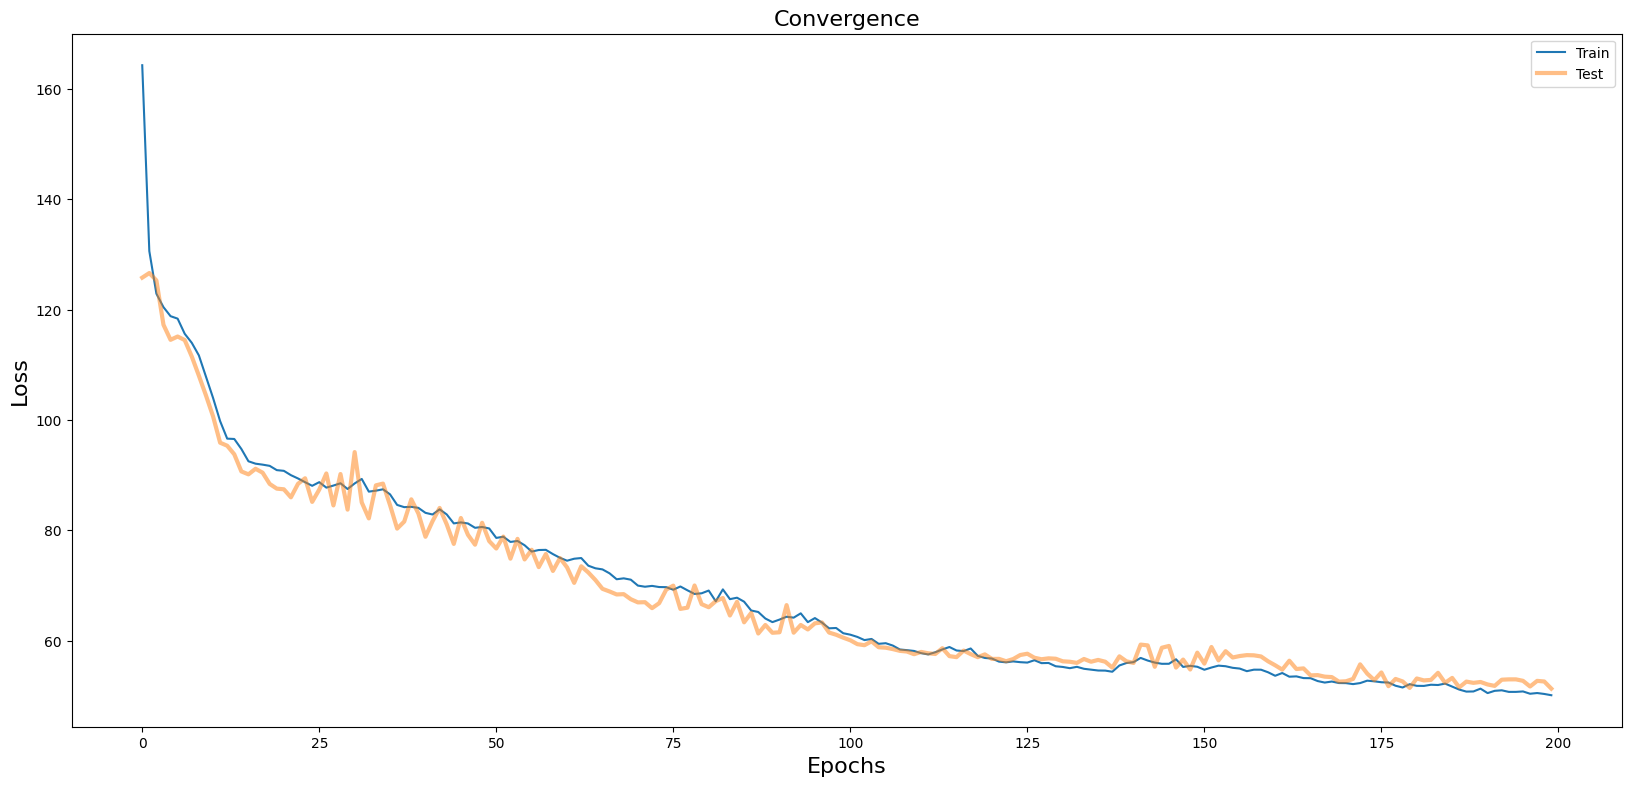

In [16]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()